### Importing Set Up - using Python 3.11.5

In [7]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import ipywidgets as widgets

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from IPython.display import display

### Database Creation

This is a separate file that we wrote to take care of all of the ETL processes.

In [8]:
execfile("Setup_and_Organization/Database Setup.py")

### SQLite Database Connection

In [9]:
engine = create_engine("sqlite:///Resources/database.sqlite")
conn=engine.connect()

# reflect an existing database into a new model
base = automap_base()
# reflect the tables
# base.prepare(engine,reflect=True)

base.prepare(autoload_with=engine)

### Data File Loading and Graph Formatting

Once we have a connection to the database, we want to get the data we desire so that we can create visualizations with that data. We create one DataFrame that all visualizations can use. While all of the joins will create many columns, we're only selecting the columns that we need for the visualizations.

In [10]:
data = pd.read_sql('SELECT g.gender_name, b.bmi_name, o.occupation_name, h.stress_level, h.heart_rate, h.systolic, h.diastolic, \
            p.gender_id, s.sleep_duration, s.sleep_quality, p.age, sd.sleep_disorder_name, s.person_id\
            FROM person AS p\
            INNER JOIN sleep AS s\
            ON s.person_id = p.id\
            INNER JOIN occupation AS o\
            ON o.id = p.occupation_id\
            INNER JOIN gender AS g\
            ON p.gender_id = g.id\
            INNER JOIN sleep_disorder AS sd\
            ON sd.id = s.sleep_disorder_id\
            INNER JOIN health AS h\
            ON h.person_id = p.id\
            INNER JOIN bmi AS b\
            ON b.id = h.bmi_id',
            conn) 

sns.set_palette("Paired")

data

,gender_name,bmi_name,occupation_name,stress_level,heart_rate,systolic,diastolic,gender_id,sleep_duration,sleep_quality,age,sleep_disorder_name,person_id
0,Male,Overweight,Software Engineer,6,77,126,83,0,6.1,6,27,None,1
1,Male,Obese,Software Engineer,8,85,140,90,0,5.9,4,28,Insomnia,6
2,Male,Normal,Software Engineer,5,70,120,80,0,7.5,8,35,None,85
3,Male,Normal,Software Engineer,5,70,120,80,0,7.5,8,35,None,93
4,Male,Normal,Doctor,8,75,125,80,0,6.2,6,28,None,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,Overweight,Scientist,6,76,128,85,1,6.2,6,33,None,69
370,Female,Overweight,Scientist,6,76,128,85,1,6.2,6,33,None,70
371,Female,Overweight,Scientist,8,81,131,86,1,5.8,4,34,Sleep Apnea,81
372,Female,Overweight,Scientist,8,81,131,86,1,5.8,4,34,Sleep Apnea,82


### Bryan's Visualization / Interaction

In [11]:
dd = widgets.Dropdown(
    options = {"Age": "age", "Stress Level": "stress_level", "Heart Rate": "heart_rate", "Systolic": "systolic", "Diastolic": "diastolic"},
    value = "age",
    description = "Category"
)

# genders = data["gender_name"].unique().tolist()

dd1 = widgets.Dropdown(
    options = ["All", "Male", "Female"],
    value = "All",
    description = "Gender"
)

# bmis = data["bmi_name"].unique().tolist()

dd2 = widgets.Dropdown(
    options = ["All", "Normal", "Overweight", "Obese"],
    value = "All",
    description = "BMI Type"
)

def draw_plot(column, item1, item2):    
    
    if (item1 == "All"):
        if (item2 == "All"):
            mask = (data["gender_name"].isin(["Male", "Female"])) & (data["bmi_name"].isin(["Normal", "Overweight", "Obese"]))
        else:
            mask = (data["gender_name"].isin(["Male", "Female"])) & (data["bmi_name"] == item2)
    else:
        if (item2 == "All"):
            mask = (data["gender_name"] == item1) & (data["bmi_name"].isin(["Normal", "Overweight", "Obese"]))
        else:
            mask = (data["gender_name"] == item1) & (data["bmi_name"] == item2)
    #sns.set_theme(style = "ticks")
    f, ax = plt.subplots(figsize = (8, 6))
    sns.boxplot(x = data.loc[mask, column],
                y = data.loc[mask, "occupation_name"], 
                hue = data["occupation_name"],
                palette = "Paired",
                width = 0.6,
                legend = False
    )
    sns.stripplot(
        x = data.loc[mask, column],
        y = data.loc[mask, "occupation_name"],
        color = "black",
        dodge = True,
        edgecolor = "black"
    )

    column_proper = column.replace("_", " ").title()
    ax.set_xlabel(column_proper, fontsize = 15)
    ax.set_ylabel("Occupation", fontsize = 15)
    plt.title(f"Distribution of {column_proper} per Occupation ({item1})", fontsize = 18)

ddbox = widgets.HBox([dd, dd1, dd2])
out1 = widgets.interactive_output(draw_plot, {"column": dd, "item1": dd1, "item2": dd2})
display(ddbox, out1)

Output()

### Reed's Visualization / Interaction

In [12]:
# Create a dropdown widget to select gender
gender_dropdown = widgets.Dropdown(
    options={'Male': 0, 'Female': 1},
    description='Gender:'
)
def draw_plot2(item):
    sns.relplot(x=data.loc[data["gender_id"] == item, "age"],
                y=data.loc[data["gender_id"]== item,"sleep_duration"],
                hue=data.loc[data["gender_id"]== item,"stress_level"],
                size=data.loc[data["gender_id"]== item,"sleep_quality"],
                sizes=(40, 400),
                alpha=.5,
                palette="Paired",
                height=6,
                data=data)\
            .set(title= "Sleep Duration vs Age")
out1= widgets.interactive_output(draw_plot2,{"item":gender_dropdown})
display(gender_dropdown,out1)

Dropdown(description='Gender:', options={'Male': 0, 'Female': 1}, value=0)

Output()

### Andrew's Visualization / Interaction

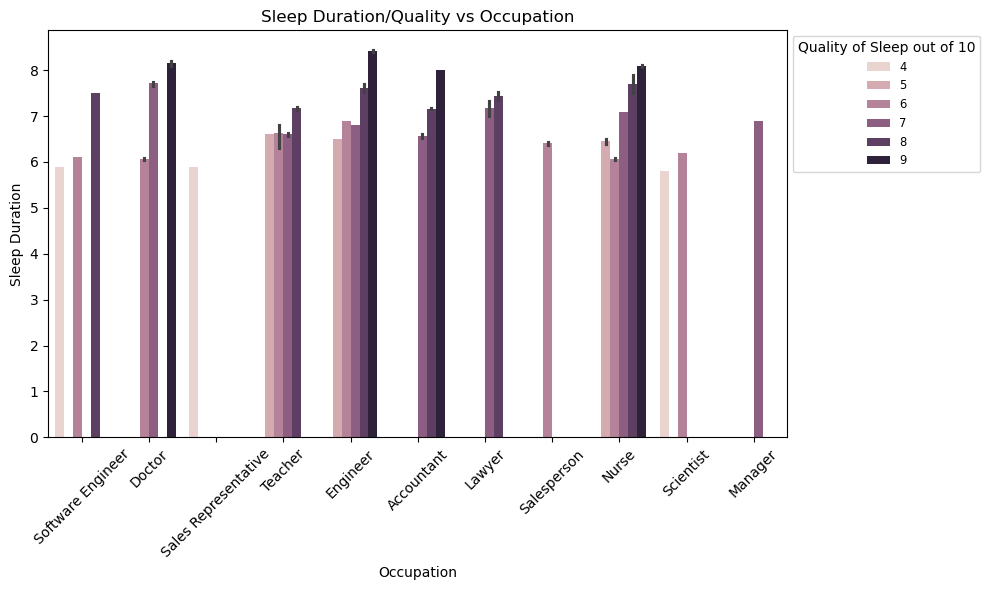

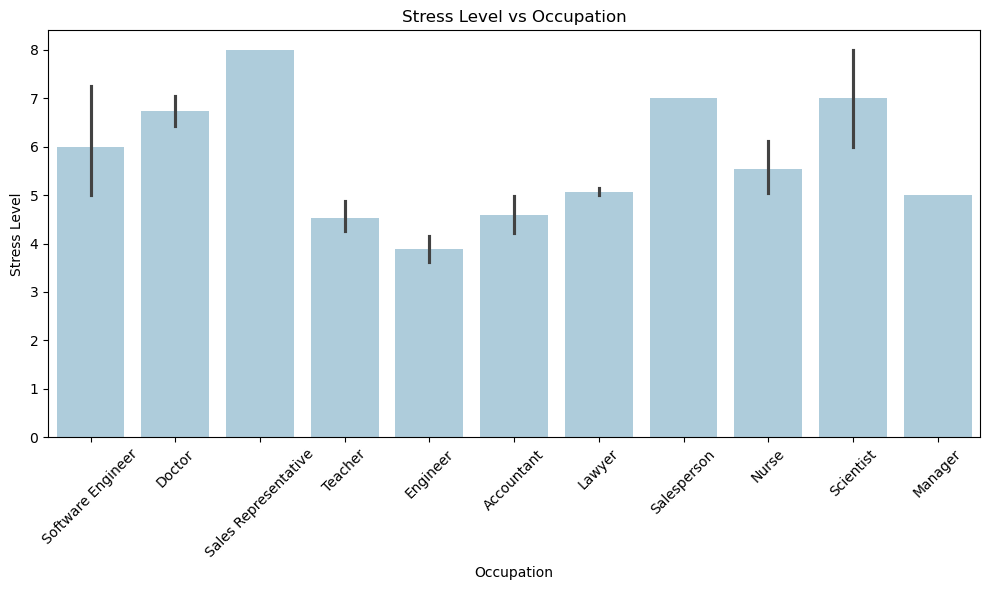

In [13]:
# Set a custom color palette
#sns.set_palette("husl")
# 1. Sleep Duration/Quality vs Occupation
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=data, x='occupation_name', y='sleep_duration', hue='sleep_quality')
plt.title('Sleep Duration/Quality vs Occupation')
plt.xlabel('Occupation')
plt.ylabel('Sleep Duration')
# Rotate the job titles by 45 degrees
plt.xticks(rotation=45)
# Customize legend labels as numbers from 0 to 10 and legend title
legend_labels = [f'{label}/10' for label in range(11)]
legend_title = 'Quality of Sleep out of 10'
legend = plt.legend(title=legend_title, loc='upper left', fontsize='small', bbox_to_anchor=(1, 1))
if len(legend_labels) == len(legend.get_texts()):
    for i, text in enumerate(legend_labels):
        legend.get_texts()[i].set_text(text)
plt.tight_layout()
# 6. Stress Level vs Occupation
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='occupation_name', y='stress_level')
plt.title('Stress Level vs Occupation')
plt.xlabel('Occupation')
plt.ylabel('Stress Level')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [14]:
data

,gender_name,bmi_name,occupation_name,stress_level,heart_rate,systolic,diastolic,gender_id,sleep_duration,sleep_quality,age,sleep_disorder_name,person_id
0,Male,Overweight,Software Engineer,6,77,126,83,0,6.1,6,27,None,1
1,Male,Obese,Software Engineer,8,85,140,90,0,5.9,4,28,Insomnia,6
2,Male,Normal,Software Engineer,5,70,120,80,0,7.5,8,35,None,85
3,Male,Normal,Software Engineer,5,70,120,80,0,7.5,8,35,None,93
4,Male,Normal,Doctor,8,75,125,80,0,6.2,6,28,None,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,Overweight,Scientist,6,76,128,85,1,6.2,6,33,None,69
370,Female,Overweight,Scientist,6,76,128,85,1,6.2,6,33,None,70
371,Female,Overweight,Scientist,8,81,131,86,1,5.8,4,34,Sleep Apnea,81
372,Female,Overweight,Scientist,8,81,131,86,1,5.8,4,34,Sleep Apnea,82


In [15]:
# Sleep Duration/Quality vs Occupation
# Set a custom color palette
#sns.set_palette("husl")

# Dropdown for selecting Sleep Quality or Sleep Duration
dd_metric = widgets.Dropdown(
    options=['Sleep Quality', 'Sleep Duration'],
    value='Sleep Quality',
    description='Metric:'
)

def plot_charts1(metric):
    if metric == 'Sleep Quality':
        plt.figure(figsize=(10, 6))
        sns.barplot(data=data, x='occupation_name', y='sleep_quality', hue='sleep_disorder_name', palette= "Paired")
        plt.title('Quality of Sleep vs Occupation')
        plt.xlabel('Occupation')
        plt.ylabel('Quality of Sleep')
        plt.xticks(rotation=45)
        legend = plt.legend(title='Sleep Disorder', loc='upper left', fontsize='small', bbox_to_anchor=(1, 1))
        legend.set_title('Sleep Disorder', prop={'size': 'small'})
        plt.tight_layout()
        plt.show()
    elif metric == 'Sleep Duration':
        plt.figure(figsize=(10, 6))
        sns.barplot(data=data, x='occupation_name', y='sleep_duration', hue='sleep_disorder_name', palette= "Paired")
        plt.title('Sleep Duration vs Occupation')
        plt.xlabel('Occupation')
        plt.ylabel('Sleep Duration')
        plt.xticks(rotation=45)
        legend = plt.legend(title='Sleep Disorder', loc='upper left', fontsize='small', bbox_to_anchor=(1, 1))
        legend.set_title('Sleep Disorder', prop={'size': 'small'})
        plt.tight_layout()
        plt.show()

def plot_charts2(metric):
    if metric == 'Sleep Quality':
        # Quality of Sleep vs Sleep Disorder
        plt.figure(figsize=(10, 6))
        sns.barplot(data=data, x='sleep_disorder_name', y='sleep_quality', hue= "sleep_disorder_name", palette= "Paired")
        plt.title('Quality of Sleep vs Sleep Disorder')
        plt.xlabel('Sleep Disorder')
        plt.ylabel('Quality of Sleep')
        plt.xticks(rotation=45)
        plt.tight_layout()
    elif metric == 'Sleep Duration':
        # Sleep Duration/Quality vs Sleep Disorder
        plt.figure(figsize=(10, 6))
        sns.barplot(data=data, x='sleep_disorder_name', y='sleep_duration', hue = "sleep_disorder_name", palette= "Paired")
        plt.title('Sleep Duration vs Sleep Disorder')
        plt.xlabel('Sleep Disorder')
        plt.ylabel('Sleep Duration')
        plt.xticks(rotation=45)
        plt.tight_layout()


# Interactive output for the plot
out_metric1 = widgets.interactive_output(plot_charts1, {'metric': dd_metric})

out_metric2 = widgets.interactive_output(plot_charts2, {"metric": dd_metric})

out_metric = widgets.HBox([out_metric1, out_metric2])


# Display dropdown and output
display(dd_metric, out_metric)

Dropdown(description='Metric:', options=('Sleep Quality', 'Sleep Duration'), value='Sleep Quality')

In [16]:
# Set a custom color palette
#sns.set_palette("husl")


### Plots 2 and 3 together

dd_gender = widgets.Dropdown(
    options = ["Male", "Female"],
    value = "Male",
    description = "Category"
)

dd_column = widgets.Dropdown(
    options = {"Sleep Duration": "sleep_duration", "Sleep Quality": "sleep_quality"},
    value = "sleep_duration",
    description = "Sleep Type"
)

def plot_barcharts1(column, gender):
    data1 = data.loc[data["gender_name"] == gender]
    #2
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=data1, y= column, hue='age')
    plt.title(f'Gender/Age vs {column.replace("_", " ").title()}')
    plt.xlabel(f'Gender ({gender})')
    plt.ylabel(column.replace("_", " ").title())
    legend = plt.legend(title='Age', loc='upper left', fontsize='small', bbox_to_anchor=(1, 1))
    legend.set_title('Age', prop={'size': 'small'})
    plt.tight_layout()

ddbox = widgets.HBox([dd_gender, dd_column])

out1 = widgets.interactive_output(plot_barcharts1, {"gender": dd_gender, "column": dd_column})

display(ddbox, out1)



# # 1. Sleep Duration/Quality vs Occupation
# plt.figure(figsize=(10, 6))
# ax = sns.barplot(data=data, x='occupation_name', y='sleep_duration', hue='sleep_quality')
# plt.title('Sleep Duration/Quality vs Occupation')
# plt.xlabel('Occupation')
# plt.ylabel('Sleep Duration')
# # Rotate the job titles by 45 degrees
# plt.xticks(rotation=45)
# # Customize legend labels as numbers from 0 to 10 and legend title
# legend_labels = [f'{label}/10' for label in range(11)]
# legend_title = 'Quality of Sleep out of 10'
# legend = plt.legend(title=legend_title, loc='upper left', fontsize='small', bbox_to_anchor=(1, 1))
# if len(legend_labels) == len(legend.get_texts()):
#     for i, text in enumerate(legend_labels):
#         legend.get_texts()[i].set_text(text)
# plt.tight_layout()

# # 4. Sleep Duration/Quality vs Sleep Disorder
# plt.figure(figsize=(10, 6))
# sns.barplot(data=data, x='sleep_disorder_name', y='sleep_duration')
# plt.title('Sleep Duration vs Sleep Disorder')
# plt.xlabel('Sleep Disorder')
# plt.ylabel('Sleep Duration')
# plt.xticks(rotation=45)
# plt.tight_layout()

# # 5. Quality of Sleep vs Sleep Disorder
# plt.figure(figsize=(10, 6))
# sns.barplot(data=data, x='sleep_disorder_name', y='sleep_quality')
# plt.title('Quality of Sleep vs Sleep Disorder')
# plt.xlabel('Sleep Disorder')
# plt.ylabel('Quality of Sleep')
# plt.xticks(rotation=45)
# plt.tight_layout()

# # 6. Stress Level vs Occupation
# plt.figure(figsize=(10, 6))
# sns.barplot(data=data, x='occupation_name', y='stress_level')
# plt.title('Stress Level vs Occupation')
# plt.xlabel('Occupation')
# plt.ylabel('Stress Level')
# plt.xticks(rotation=45)
# plt.tight_layout()

# plt.show()

Output()

### Tom's Visualization / Interaction

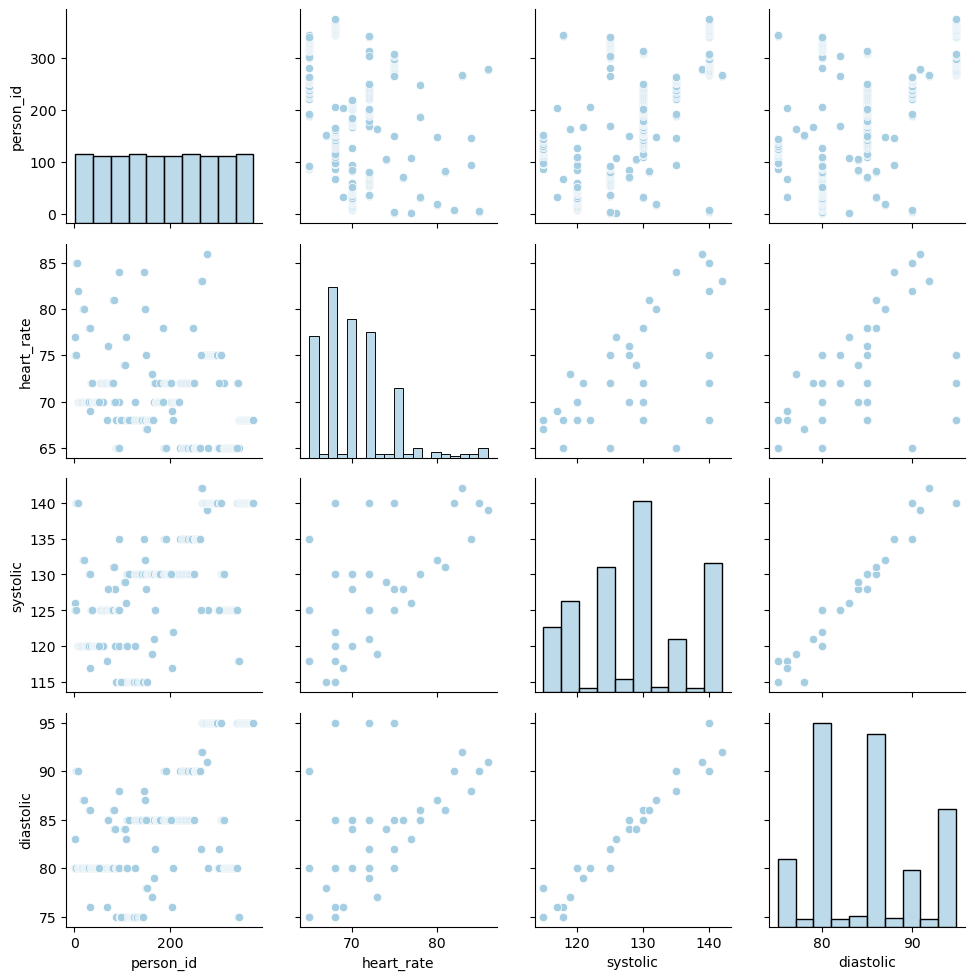

In [17]:
health_metrics = data[['person_id','heart_rate','systolic','diastolic']]
h_diag = sns.PairGrid(data=health_metrics)
h_diag.map_diag(sns.histplot)
h_diag.map_offdiag(sns.scatterplot)
plt.show()

In [18]:
engine.dispose()